# Fase 05: Inferencia utilizando el acelerador Hailo 8L

In [12]:
# Imports

from multiprocessing import Process

import numpy as np

from hailo_platform import (
    HEF,
    ConfigureParams,
    FormatType,
    HailoSchedulingAlgorithm,
    HailoStreamInterface,
    InferVStreams,
    InputVStreamParams,
    InputVStreams,
    OutputVStreamParams,
    OutputVStreams,
    VDevice,
)

# from hailo_sdk_client import ClientRunner, InferenceContext

import time

# Funciones y parámetros de la CNN base
import sys
sys.path.append('../src/models')

from cnn21_pix import *

import matplotlib.pyplot as plt

## 1. Inferencia mediante flujo independiente

### 1.1. Definición de parámetros

In [2]:
# Setting VDevice params to disable the HailoRT service feature
params = VDevice.create_params()
params.scheduling_algorithm = HailoSchedulingAlgorithm.NONE

# The target can be used as a context manager ("with" statement) to ensure it's released on time.
# Here it's avoided for the sake of simplicity
target = VDevice(params=params)

# Loading compiled HEFs to device:
optimization_level = 0
compression_level = 0
model_name = f"../results/model_cnn21_o{optimization_level}_c{compression_level}"
hef_path = f"{model_name}.hef"
hef = HEF(hef_path)

# Get the "network groups" (connectivity groups, aka. "different networks") information from the .hef
configure_params = ConfigureParams.create_from_hef(hef=hef, interface=HailoStreamInterface.PCIe)
network_groups = target.configure(hef, configure_params)
network_group = network_groups[0]
network_group_params = network_group.create_params()

# Create input and output virtual streams params
# Quantized argument signifies whether or not the incoming data is already quantized.
# Data is quantized by HailoRT if and only if quantized == False .
input_vstreams_params = InputVStreamParams.make(network_group, quantized=False, format_type=FormatType.FLOAT32)
output_vstreams_params = OutputVStreamParams.make(network_group, quantized=True, format_type=FormatType.UINT8)

# Obtener información de entrada/salida
input_vstream_info = hef.get_input_vstream_infos()[0]
output_vstream_info = hef.get_output_vstream_infos()[0]
image_height, image_width, num_bands = input_vstream_info.shape

### 1.2. Carga del dataset y ejecución de la inferencia

In [6]:
# Cargar el dataset y ejecutar la inferencia

# Se mide el tiempo total de carga y ejecución
start_time = time.time()

# Definir parámetros

DATASET='../data/imagenes_rios/oitaven_river.raw'
GT='../data/imagenes_rios/oitaven_river.pgm'

# Queremos usar todos los datos para la inferencia
SAMPLES=[0,0]
PAD=1
AUM=0

os.environ['HAILO_MONITOR'] = '1'

# Carga de datos

(datos,H,V,B)=read_raw(DATASET)
(truth,H1,V1)=read_pgm(GT)

# Durante la ejecucion de la red vamos a coger patches de tamano cuadrado
sizex=32; sizey=32 

# Hacemos padding en el dataset para poder aprovechar hasta el borde
if(PAD):
    datos=torch.FloatTensor(np.pad(datos,((sizey//2,sizey//2),(sizex//2,sizex//2),(0,0)),'symmetric'))
    H=H+2*(sizex//2); V=V+2*(sizey//2)
    truth=np.reshape(truth,(-1,H1))
    truth=np.pad(truth,((sizey//2,sizey//2),(sizex//2,sizex//2)),'constant')
    H1=H1+2*(sizex//2); V1=V1+2*(sizey//2)
    truth=np.reshape(truth,(H1*V1))
    
# Necesitamos los datos en band-vector para hacer convoluciones
datos=np.transpose(datos,(2,0,1))

# Seleccionar conjunto de test (en este caso es una predicción)
(train,val,test,nclases,nclases_no_vacias)=select_training_samples(truth,H,V,sizex,sizey,SAMPLES)
dataset_test=HyperDataset(datos,truth,test,H,V,sizex,sizey)
print('  - test dataset:',len(dataset_test))

# Dataloader
batch_size=100 # defecto 100

test_loader=DataLoader(dataset_test,batch_size,shuffle=False)

# Ejecutar la inferencia

output=np.zeros(H*V,dtype=np.uint8)

with InferVStreams(network_group, input_vstreams_params, output_vstreams_params) as infer_pipeline:
    with network_group.activate(network_group_params):
        total = 0
        
        for (inputs, labels) in test_loader:
            # Convertir inputs a un formato adecuado para hailo
            inputs_np = inputs.numpy()
            inputs_hailo = np.transpose(inputs_np, (0, 2, 3, 1))

            # Asegurarse de que los datos sean contiguos en memoria
            inputs_hailo = np.ascontiguousarray(inputs_hailo.astype(np.float32))
            
            # Realizar la inferencia
            input_data = {input_vstream_info.name: inputs_hailo}
            
            infer_results = infer_pipeline.infer(input_data)

            predicted=np.argmax(infer_results[output_vstream_info.name], axis=1)

            # Asignar las predicciones al array de salida
            for i in range(len(predicted)):
                output[test[total+i]]=np.uint8(predicted[i]+1)
            total+=labels.size(0)

            # Mostrar el progreso
            if(total%100000==0): print('  Test:',total,'/',len(dataset_test))

end_time = time.time()

print("Prediction time: {:.4f} seconds".format(end_time - start_time))

  Test: 100000 / 6067179
  Test: 200000 / 6067179
  Test: 300000 / 6067179
  Test: 400000 / 6067179
  Test: 500000 / 6067179
  Test: 600000 / 6067179
  Test: 700000 / 6067179
  Test: 800000 / 6067179
  Test: 900000 / 6067179
  Test: 1000000 / 6067179
  Test: 1100000 / 6067179
  Test: 1200000 / 6067179
  Test: 1300000 / 6067179
  Test: 1400000 / 6067179
  Test: 1500000 / 6067179
  Test: 1600000 / 6067179
  Test: 1700000 / 6067179
  Test: 1800000 / 6067179
  Test: 1900000 / 6067179
  Test: 2000000 / 6067179
  Test: 2100000 / 6067179
  Test: 2200000 / 6067179
  Test: 2300000 / 6067179
  Test: 2400000 / 6067179
  Test: 2500000 / 6067179
  Test: 2600000 / 6067179
  Test: 2700000 / 6067179
  Test: 2800000 / 6067179
  Test: 2900000 / 6067179
  Test: 3000000 / 6067179
  Test: 3100000 / 6067179
  Test: 3200000 / 6067179
  Test: 3300000 / 6067179
  Test: 3400000 / 6067179
  Test: 3500000 / 6067179
  Test: 3600000 / 6067179
  Test: 3700000 / 6067179
  Test: 3800000 / 6067179
  Test: 3900000 / 606

### 1.3. Evaluación del desempeño del modelo

In [19]:
# Evaluar el desempeño del modelo

# Precisiones a nivel de clase
correct=0; total=0; AA=0; OA=0
class_correct=[0]*(nclases+1)
class_total=[0]*(nclases+1)
class_aa=[0]*(nclases+1)

for i in test:
    if(output[i]==0 or truth[i]==0): continue
    total+=1; class_total[truth[i]]+=1
    if(output[i]==truth[i]):
          correct+=1
          class_correct[truth[i]]+=1
for i in range(1,nclases+1):
    if(class_total[i]!=0): class_aa[i]=100*class_correct[i]/class_total[i]
    else: class_aa[i]=0
    AA+=class_aa[i]
OA=100*correct/total; AA=AA/nclases_no_vacias

for i in range(1,nclases+1): print('  Class %02d: %02.02f'%(i,class_aa[i]))
print('* Accuracy (pixels) OA=%02.02f, AA=%02.02f'%(OA,AA))
print('  total:',total,'correct:',correct)

  Class 01: 98.09
  Class 02: 92.82
  Class 03: 57.62
  Class 04: 98.81
  Class 05: 75.54
  Class 06: 86.80
  Class 07: 97.76
  Class 08: 81.75
  Class 09: 94.68
  Class 10: 63.64
* Accuracy (pixels) OA=86.78, AA=84.75
  total: 6067179 correct: 5265020


In [20]:
# Guardar la salida

if(PAD):
    output=np.reshape(output,(-1,H1))
    output=output[sizey//2:V1-sizey//2,sizex//2:H1-sizex//2]
    H1=H1-2*(sizex//2); V1=V1-2*(sizey//2)
    output=np.reshape(output,(H1*V1))

save_pgm(output,H1,V1,nclases,f'../results/predictions_rpi_cnn21_o{optimization_level}_c{compression_level}.pgm')

* Saved file: ../results/predictions_rpi_cnn21.pgm


* Read GT: ../results/predictions_rpi_cnn21.pgm
  H: 6722 V: 6689 depth: 10
  Read: 44963458


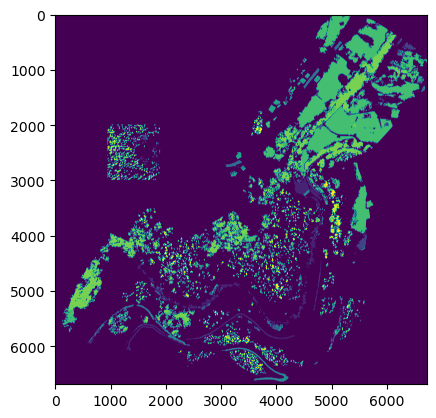

In [21]:
# Mostrar la salida

OUTPUT=f'../results/predictions_rpi_cnn21_o{optimization_level}_c{compression_level}.pgm'

(imagen_output, H1, V1) = read_pgm(OUTPUT)

# Convertir la lista a array y redimensionar
imagen_output = np.array(imagen_output, dtype=np.uint8).reshape(V1, H1)

# Mostrar la imagen
plt.imshow(imagen_output)
plt.show()